# Simulation

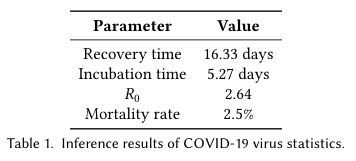

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd

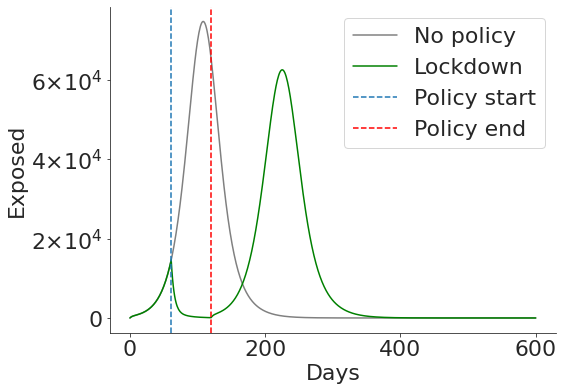

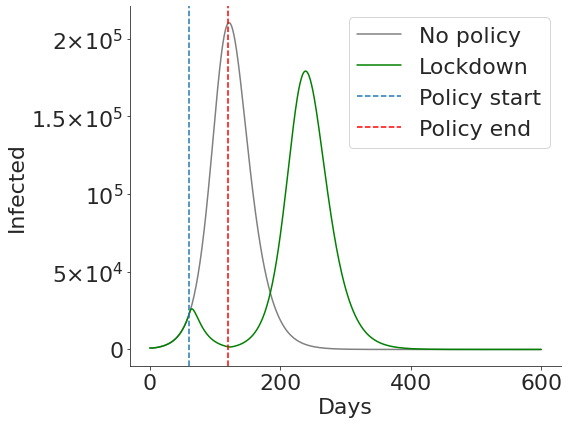

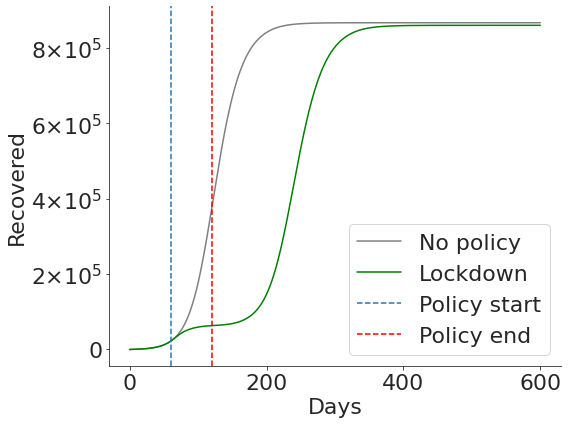

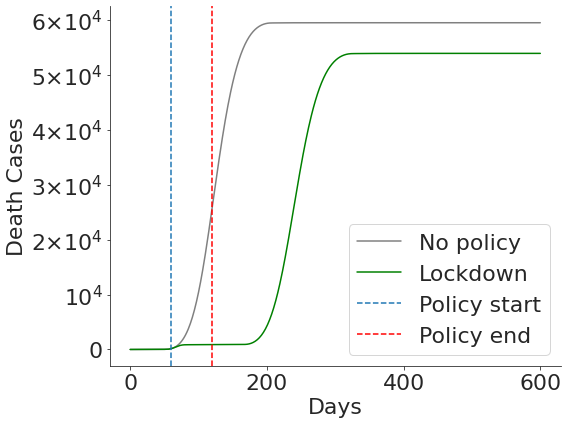

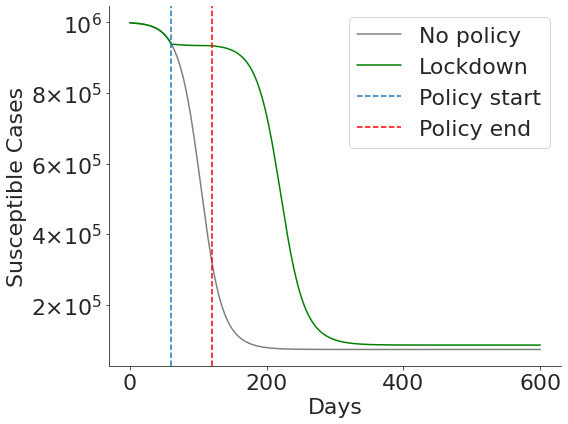

In [ ]:

hygiene = 0.30   
distancing = 0.74 
lockdown = 0.96
quarantine = 0.96 

hospital_cap = 2.2/1000
transmission_days = 16.33/2.64
exposed_days = 5.27
recovery_days = 16.33 

susceptible0 = 0.999
infected0 = 0.001
exposed0 = 0
recovered0 = 0

population = 1000000

def virus_model(days,policy):

  if policy == "hygiene":
    pol = hygiene
  elif policy == "distancing":
    pol = distancing
  elif policy == "lockdown":
    pol = lockdown
  elif policy == "quarantine":
    pol = quarantine
  elif policy == "None":
    pol = None

  transmission_rate = (1/ transmission_days)
  incubation_rate = (1/  exposed_days)
  recovery_rate = (1/ recovery_days)
  death_rate_with_med = 0.025
  death_rate_without_med = 0.9
  ser_case_rate = 0.15


  r0 = 2.64

  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  re = [r0]
  d = [0]
  testing = 0
  
  for day in range(days):
    if 60 < day < 120  and pol != None:
      transmission_rate = (1/ transmission_days) * (1-pol)
    else:
      transmission_rate = (1/ transmission_days)
    
    S2E = susceptible * infected * transmission_rate
    E2I = exposed * incubation_rate
    if (ser_case_rate*infected < hospital_cap):
      I2D = ser_case_rate*infected*death_rate_with_med/30
    else:
      I2D = hospital_cap*death_rate_with_med/30 + (ser_case_rate*infected - hospital_cap) * death_rate_without_med/30
    I2R = (infected - I2D*30)*recovery_rate
    exposed +=  S2E
    susceptible -= S2E
    infected += E2I
    exposed -= E2I
    recovered += I2R
    infected -= I2R
    infected -= I2D
    dead += I2D

    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
  
  return susc, exp, inf, rec, d, re

days = 600

result_h = virus_model(days,'hygiene')
result_d = virus_model(days,'distancing')
result_l = virus_model(days,'lockdown')
result_q = virus_model(days,'quarantine')
result_0 = virus_model(days,'None')

m = [m for m in range(days+1)]

import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib
result = result_0
from matplotlib.ticker import FormatStrFormatter

sns.set_style("ticks")
matplotlib.rcParams['figure.figsize'] = 8, 6
sns.despine()
formatter = mticker.ScalarFormatter(useMathText=True)
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%10e' % x))


plt.plot(m, result[1], label="No policy", color ='grey')
plt.plot(m, result_l[1], label="Lockdown", color ='green')
plt.axvline(x=60,linestyle='--', linewidth=1.5,  label='Policy start')
plt.axvline(x=120,linestyle='--', linewidth=1.5, color='red', label='Policy end')
plt.tick_params(labelsize=22)
plt.ylabel('Exposed', fontsize=22)
plt.xlabel('Days', fontsize=22)
plt.legend(fontsize=22)
sns.despine()
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))

plt.savefig('/content/sample_data/E.pdf',bbox_inches='tight')
plt.show()

plt.plot(m, result[2], label="No policy", color ='grey')
plt.plot(m, result_l[2], label="Lockdown", color ='green')
plt.axvline(x=60,linestyle='--', linewidth=1.5,  label='Policy start')
plt.axvline(x=120,linestyle='--', linewidth=1.5, color='red', label='Policy end')
plt.tick_params(labelsize=22)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.gca().yaxis.get_offset_text().set_fontsize(16)

plt.ylabel('Infected',fontsize=22)
plt.xlabel('Days',fontsize=22)
plt.legend(fontsize=22)
sns.set_style("ticks")
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/I.pdf',bbox_inches='tight')
plt.show()

plt.plot(m, result[3], label="No policy", color ='grey')
plt.plot(m, result_l[3], label="Lockdown", color ='green')
plt.axvline(x=60,linestyle='--', linewidth=1.5,  label='Policy start')
plt.axvline(x=120,linestyle='--', linewidth=1.5, color='red', label='Policy end')
plt.tick_params(labelsize=22)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.gca().yaxis.get_offset_text().set_fontsize(16)


plt.ylabel('Recovered',fontsize=22)
plt.xlabel('Days',fontsize=22)
plt.legend(fontsize=22)
sns.set_style("ticks")
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/R.pdf',bbox_inches='tight')
plt.show()

plt.plot(m, result[4], label="No policy", color ='grey')
plt.plot(m, result_l[4], label="Lockdown", color ='green')
plt.axvline(x=60,linestyle='--', linewidth=1.5,  label='Policy start')
plt.axvline(x=120,linestyle='--', linewidth=1.5, color='red', label='Policy end')
plt.tick_params(labelsize=22)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.gca().yaxis.get_offset_text().set_fontsize(16)


plt.ylabel('Death Cases',fontsize=22)
plt.xlabel('Days',fontsize=22)
sns.set_style("ticks")
plt.legend(fontsize=22)
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/D.pdf')
plt.show()

plt.plot(m, result[0], label="No policy", color ='grey')
plt.plot(m, result_l[0], label="Lockdown", color ='green')
plt.axvline(x=60,linestyle='--', linewidth=1.5,  label='Policy start')
plt.axvline(x=120,linestyle='--', linewidth=1.5, color='red', label='Policy end')
plt.tick_params(labelsize=22)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.gca().yaxis.get_offset_text().set_fontsize(16)


plt.ylabel('Susceptible Cases',fontsize=22)
plt.xlabel('Days',fontsize=22)
sns.set_style("ticks")
plt.legend(fontsize=22)
plt.tight_layout()
sns.despine()
plt.savefig('/content/sample_data/S.pdf')
plt.show()


# Policy Efficacy check


In [14]:

import numpy as np
def evaluate(inf, rec, d, policy, cont_tracing):
# Set penalty points
  dd_point = -7000 # death
  inf_point = -0.3 # infection

  result = sum(inf)*inf_point + d[-1]*dd_point + sum(policy) + sum(cont_tracing)*6.4
  return result


In [15]:
test_cap = 0.001
hygiene = 0.30 
distancing = 0.74 
lockdown = 0.96
quarantine = 0.96 

hospital_cap = 6/10000
transmission_days = 16.33/2.40 
exposed_days = 5.27 
recovery_days = 16.33 


susceptible0 = 0.99
infected0 = 0.01
exposed0 = 0
recovered0 = 0

population = 1000000


def virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list):

  assert len(hygiene_list) == len(distancing_list) == len(lockdown_list) == len(quarantine_list)

  duration = len(hygiene_list)

  
  transmission_rate0 = (1/ transmission_days)
  incubation_rate = (1/  exposed_days)
  recovery_rate = (1/ recovery_days)
  death_rate_with_med = 0.6
  death_rate_without_med = 1
  general_dr = 0.02
  icu_case_rate = 0.06

  r0 = 2.64

  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  cont_tracing = []
  re = [r0]
  d = [0]
  policy = []
  
  testing = 0

  for day in range(duration):
    transmission_rate = transmission_rate0 * (1- hygiene_list[day]*hygiene) * (1- distancing_list[day]*distancing) * (1- lockdown_list[day]*lockdown) * (1- quarantine_list[day]*quarantine)
    ld_point = - population * 0.1 * 30 /365
    # qr_point = - population * infected * 0.1 - population * 0.1 * 15 /365
    qr_point =  - population * 0.1 * 15 /365
    hg_point = - population * 0.002
    dst_point = - population * 0.1 * 15 /365 
    policy_point = hg_point * hygiene_list[day] + dst_point * distancing_list[day] + ld_point*lockdown_list[day] + qr_point*quarantine_list[day]

    S2E = susceptible * infected * transmission_rate
    E2I = exposed * incubation_rate
    I2D = general_dr*infected/recovery_days
    if (icu_case_rate*infected < hospital_cap):
      I2D += icu_case_rate*infected*death_rate_with_med/recovery_days
    else:
      I2D += hospital_cap*death_rate_with_med/recovery_days + (icu_case_rate*infected - hospital_cap) * death_rate_without_med/recovery_days
    I2R = (1-general_dr)*infected*recovery_rate

    exposed +=  S2E
    susceptible -= S2E
    infected += E2I
    exposed -= E2I
    recovered += I2R
    infected -= I2R
    infected -= I2D
    dead += I2D

    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
    policy.append(policy_point)

    cont_tracing.append(S2E*quarantine_list[day]*population)

  return susc, exp, inf, rec, d, re, policy, cont_tracing


result = np.zeros((3,3,3,3,3,3,3,3,3,3,3,3), dtype = float)
for index, value in np.ndenumerate(result):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = index
  # Filter out unreasonable cases: Lockdown and social distancing in the same month 
  # OR Distacing and (distabncing + tracing) in the same month
  if (d1!=0 and q1!=0) or (d2!=0 and q2!=0) or (d3!=0 and q3!=0) or \
  (l1!=0 and (q1!=0 or d1!=0)) or (l2!=0 and (d2!=0 or q2!=0)) or (l3!=0 and (d3!=0 or q3!=0)):
    result[h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3] = None
    continue
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  result[h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3] = point
print(result[0,0,0,0,0,0,0,0,0,0,0,0]) #no policy case


-197972647.11065745


In [16]:
import pickle
with open('result.pkl','wb') as f:
     pickle.dump(result, f)
 
with open('result.pkl','rb') as f:
     x = pickle.load(f)
     print(x.shape)

(3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3)


In [17]:
loss = np.nanmax(x)
arg =  np.unravel_index(np.nanargmax(x), result.shape)
print(loss, arg)
x[0,0,0,0,0,0,0,0,0,2,2,2]

-4516583.105041612 (2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2)


-4556337.416101954

# Plot the graph

In [18]:
index = []
index.append([0,0,0,0,0,0,0,0,0,0,0,0])
index.append([2,2,2,0,0,0,0,0,0,0,0,0])
index.append([0,0,0,2,2,2,0,0,0,0,0,0])
index.append([0,0,0,0,0,0,2,2,2,0,0,0])
index.append([0,0,0,0,0,0,0,0,0,2,2,2])
index.append([2,0,0,0,0,0,0,0,0,2,2,2]) # optimal combination

In [19]:
ind = np.unique(np.asarray(index), axis = 0)
ind.shape

(6, 12)

In [20]:

def virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list):

  assert len(hygiene_list) == len(distancing_list) == len(lockdown_list) == len(quarantine_list)

  duration = len(hygiene_list)

  
  transmission_rate0 = (1/ transmission_days)
  incubation_rate = (1/  exposed_days)
  recovery_rate = (1/ recovery_days)
  death_rate_with_med = 0.6
  death_rate_without_med = 1
  general_dr = 0.02
  icu_case_rate = 0.06

  r0 = 2.64

  susceptible =  susceptible0
  infected = infected0
  exposed = exposed0
  recovered = recovered0
  dead = 0

  susc= [population * susceptible0]
  exp = [population * exposed0]
  inf = [population * infected0]
  rec = [population * recovered0]
  cont_tracing = []
  re = [r0]
  d = [0]
  policy = []
  
  testing = 0


  for day in range(duration):
    transmission_rate = transmission_rate0 * (1- hygiene_list[day]*hygiene) * (1- distancing_list[day]*distancing) * (1- lockdown_list[day]*lockdown) * (1- quarantine_list[day]*quarantine)
    ld_point = - population * 0.1 * 30 /365
    qr_point = - population * infected * 0.1 - population * 0.1 * 15 /365
    hg_point = - population * 0.002
    dst_point = - population * 0.1 * 15 /365 
    policy_point = hg_point * hygiene_list[day] + dst_point * distancing_list[day] + ld_point*lockdown_list[day] + qr_point*quarantine_list[day]

    S2E = susceptible * infected * transmission_rate
    E2I = exposed * incubation_rate
    I2D = general_dr*infected/recovery_days
    if (icu_case_rate*infected < hospital_cap):
      I2D += icu_case_rate*infected*death_rate_with_med/recovery_days
    else:
      I2D += hospital_cap*death_rate_with_med/recovery_days + (icu_case_rate*infected - hospital_cap) * death_rate_without_med/recovery_days
    I2R = (1-general_dr)*infected*recovery_rate

    exposed +=  S2E
    susceptible -= S2E
    infected += E2I
    exposed -= E2I
    recovered += I2R
    infected -= I2R
    infected -= I2D
    dead += I2D

    re.append((transmission_rate/ recovery_rate)*susceptible)
    susc.append(population* susceptible)
    exp.append(population* exposed)
    inf.append(population* infected)
    rec.append(population* recovered)
    d.append(population* dead)
    policy.append(policy_point)
    cont_tracing.append(S2E*quarantine_list[day]*population)
  
  return susc, exp, inf, rec, d, re, policy, cont_tracing


def evaluate(inf, rec, d, policy, cont_tracing):

  dd_point = -7000
  inf_point = -0.3
  contact_tracing_point = 6.4

  result = [-1000*(sum(inf[:i])*inf_point + d[i]*dd_point + sum(policy[:i])+ contact_tracing_point*sum(cont_tracing[:i])) for i in range(len(d))]
  return result

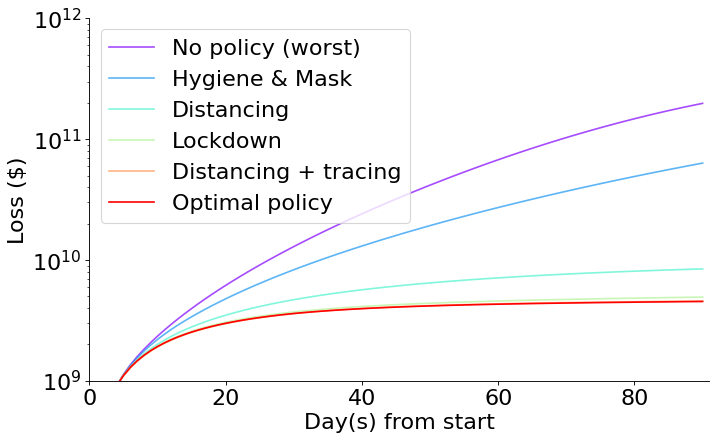

In [22]:
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

legends = ['No policy (worst)', 'Hygiene & Mask', 'Distancing', 'Lockdown', 'Distancing + tracing', 'Optimal policy']
al = [0.7]*5+[1]
col = cm.rainbow(np.linspace(0, 1, 6))
plt.yscale('log')
for i,indice in enumerate(index):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = indice
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  m = [m for m in range(91)]
  plt.plot(m, point, label=legends[i], alpha = al[i], color = col[i])
  plt.plot()

plt.legend(loc = 'upper left', fontsize = 20)
plt.ylim([10**9, 10**12])
plt.xlim([0, 91])
plt.xlabel('Day(s) from start', fontsize = 20)
plt.ylabel('Loss ($)', fontsize = 20)
sns.despine()
plt.rcParams["figure.figsize"] = (10, 10)
plt.tick_params(labelsize=20)
plt.savefig('/content/sample_data/loss.pdf')


# Make table

In [24]:
res = []
keys = ['M', 'D', 'L', 'T']
for i,indice in enumerate(index):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = indice
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  print(point)
  label = ''
  for i in [0, 3, 6, 9]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [0, 3, 6, 9]]) == 0:
      label += '-'
  label += ' | '
  for i in [1, 4, 7, 10]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [1, 4, 7, 10]]) == 0:
      label += '-'
  label += ' | '
  for i in [2, 5, 8, 11]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [2, 5, 8, 11]]) == 0:
      label += '-'
  res.append([label, int(1000000-susc[-1]), int(d[-1]), point[-1]/1000000000])




[-0.0, 243048989.58971217, 470678582.1668743, 690577331.1735109, 908237760.8551673, 1127633311.3754811, 1351688723.9838376, 1582607088.6732883, 1822097374.9588842, 2074236122.0474293, 2342150151.2319617, 2627239907.0491276, 2930770376.0273614, 3253924474.7595596, 3597840495.176862, 3963638463.533936, 4352438784.206866, 4765375507.530481, 5203605843.889663, 5668317047.890548, 6160731449.867514, 6682110170.847734, 7233755889.18961, 7817014910.067934, 8433278707.264355, 9083985049.549042, 9770618783.818312, 10494712318.882685, 11257845833.772503, 12061647220.14198, 12907791758.07521, 13798001517.133377, 14734044469.007896, 15717733294.09704, 16750923861.323364, 17835513358.30278, 18973438047.40031, 20166670622.162304, 21417217138.044987, 22727113491.241478, 24098421419.742825, 25533224001.568817, 27033620626.39734, 28601721418.640667, 30239641092.40032, 31949492221.718967, 33733377913.174995, 35593383872.168655, 37531569859.25571, 39549960538.61687, 41650535727.21853, 43835220060.41985, 4

Table represents loss regarding applied policies. The most effective policy combination is listed at the top. The meaning of policy notatioin is as follows:

*   None: Doing nothing
*   Uppercase: full efficacy
*   Lowercase: half efficacy


*   L/l: Lockdown
*   T/t: Tracing with distancing
*   D/d: Distancing
*   M/m: Masks and Hygiene

*Example: L | l | D denotes the consecutive policy execution of full lockdown (1st month), half lockdown (2nd month) and full distancing (3rd month).*










In [25]:
df = pd.DataFrame(res, columns = ['Policy combination', 'Cases', 'Deaths', 'Loss'])
df = df.set_index('Policy combination')
df.sort_values(by='Loss')

,Cases,Deaths,Loss
Policy combination,,,
MT | T | T,10734,577,4.533401
T | T | T,11003,591,4.573572
L | L | L,11003,591,4.932606
D | D | D,22478,1138,8.436941
M | M | M,201929,8941,63.400395
- | - | -,592136,28018,197.926939


# More results

In [26]:
# For more results:
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[-k:]
    return np.column_stack(np.unravel_index(idx, a.shape))

def k_smallest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:k]
    return np.column_stack(np.unravel_index(idx, a.shape))

x = result
# Choose bottom k combinations
k = 5
idx = k_smallest_index_argsort(x, k)
index.extend(idx.tolist())

# Choose top n combinations
n = 5
idx = k_largest_index_argsort(x, n)
index.extend(idx.tolist())

In [28]:
res = []
keys = ['M', 'D', 'L', 'T']
for i,indice in enumerate(index):
  h1, h2, h3, d1, d2, d3, l1, l2, l3, q1, q2, q3 = indice
  hygiene_list = [h1/2]*30 + [h2/2]*30 + [h3/2]*30
  distancing_list = [d1/2]*30 + [d2/2]*30 + [d3/2]*30
  lockdown_list = [l1/2]*30 + [l2/2]*30 + [l3/2]*30
  quarantine_list = [q1/2]*30 + [q2/2]*30 + [q3/2]*30
  susc, exp, inf, rec, d, re, policy,cont_tracing = virus_model(hygiene_list, distancing_list,lockdown_list,quarantine_list)        
  point = evaluate(inf, rec, d, policy,cont_tracing)
  print(point)
  label = ''
  for i in [0, 3, 6, 9]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [0, 3, 6, 9]]) == 0:
      label += '-'
  label += ' | '
  for i in [1, 4, 7, 10]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [1, 4, 7, 10]]) == 0:
      label += '-'
  label += ' | '
  for i in [2, 5, 8, 11]:
    if indice[i] == 2:
      label += keys[i//3]
    if indice[i] == 1:
      label += keys[i//3].lower()
  if sum([indice[i] for i in [2, 5, 8, 11]]) == 0:
      label += '-'
  res.append([label, int(1000000-susc[-1]), int(d[-1]), point[-1]/1000000000])




[-0.0, 243048989.58971217, 470678582.1668743, 690577331.1735109, 908237760.8551673, 1127633311.3754811, 1351688723.9838376, 1582607088.6732883, 1822097374.9588842, 2074236122.0474293, 2342150151.2319617, 2627239907.0491276, 2930770376.0273614, 3253924474.7595596, 3597840495.176862, 3963638463.533936, 4352438784.206866, 4765375507.530481, 5203605843.889663, 5668317047.890548, 6160731449.867514, 6682110170.847734, 7233755889.18961, 7817014910.067934, 8433278707.264355, 9083985049.549042, 9770618783.818312, 10494712318.882685, 11257845833.772503, 12061647220.14198, 12907791758.07521, 13798001517.133377, 14734044469.007896, 15717733294.09704, 16750923861.323364, 17835513358.30278, 18973438047.40031, 20166670622.162304, 21417217138.044987, 22727113491.241478, 24098421419.742825, 25533224001.568817, 27033620626.39734, 28601721418.640667, 30239641092.40032, 31949492221.718967, 33733377913.174995, 35593383872.168655, 37531569859.25571, 39549960538.61687, 41650535727.21853, 43835220060.41985, 4

In [29]:
df = pd.DataFrame(res, columns = ['Policy combination', 'Cases', 'Deaths', 'Loss'])
df = df.set_index('Policy combination')
df.sort_values(by='Loss')

,Cases,Deaths,Loss
Policy combination,,,
MT | T | T,10734,577,4.533401
T | T | T,11003,591,4.573572
L | L | L,11003,591,4.932606
MDLT | MDLT | MDLT,10006,539,5.498194
D | D | D,22478,1138,8.436941
mt | Lt | Dl,26023,1378,10.382875
mt | Lt | Dlt,25736,1370,10.391679
mt | L | DlT,25887,1383,10.479649
m | L | DT,59338,3502,25.320860
